In [24]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\T.B\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\T.B\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
df = pd.read_csv(r"C:\Users\T.B\Downloads\IMDB Dataset.csv", engine='python', on_bad_lines='skip')
print('Class distribution:')
print(df['sentiment'].value_counts())


Class distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [26]:

def clean_text(text):
    text = re.sub(r'<.*?>', '', str(text))
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def remove_stopwords_lemmatize(text):
    words = []
    for w in text.split():
        if w not in stop_words:
            words.append(lemmatizer.lemmatize(w))
    return ' '.join(words)

df['clean_review'] = df['review'].apply(clean_text).apply(remove_stopwords_lemmatize)

df[['review', 'clean_review']].head()


,review,clean_review
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


In [27]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentiment'])
print(df[['sentiment','label']].head())


  sentiment  label
0  positive      1
1  positive      1
2  positive      1
3  negative      0
4  positive      1


In [28]:
max_words = 20000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['clean_review'])

sequences = tokenizer.texts_to_sequences(df['clean_review'])

padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

X = padded_sequences
y = df['label'].values


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Training samples:', X_train.shape[0])
print('Test samples:', X_test.shape[0])


Training samples: 40000
Test samples: 10000


In [ ]:
model = Sequential([
    Embedding(max_words, 128),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)        


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 955s 2s/step - accuracy: 0.7932 - loss: 0.4515 - val_accuracy: 0.8303 - val_loss: 0.3981
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 993s 2s/step - accuracy: 0.8825 - loss: 0.3043 - val_accuracy: 0.8583 - val_loss: 0.3416
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 953s 2s/step - accuracy: 0.8928 - loss: 0.2782 - val_accuracy: 0.8489 - val_loss: 0.3766
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 924s 2s/step - accuracy: 0.9284 - loss: 0.1974 - val_accuracy: 0.8634 - val_loss: 0.3529
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 942s 2s/step - accuracy: 0.9459 - loss: 0.1552 - val_accuracy: 0.8347 - val_loss: 0.4312


Test Accuracy: 0.8637
313/313 ━━━━━━━━━━━━━━━━━━━━ 61s 191ms/step
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4961
           1       0.87      0.86      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



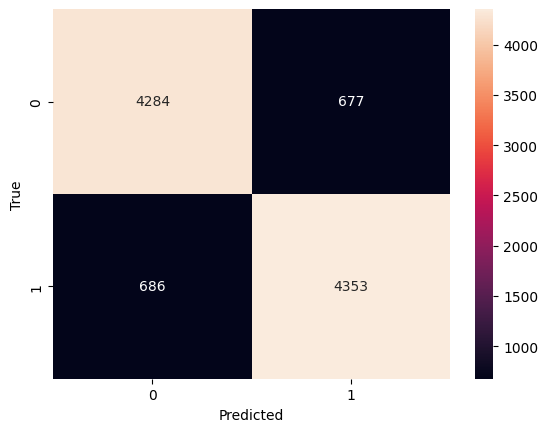

In [32]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
